# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


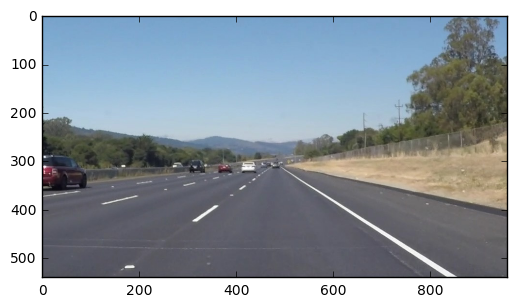

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
def grayscale(image):
    """
    :param image: original image to be converted
    Applies the Grayscale transform
    This will return an image with only one color channel
    """
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


def gaussian_blur(image, kernel):
    """Applies a Gaussian Noise kernel
    :param image:  image to blur
    :param kernel:  size of gaussian kernel
    :return: blurred image
    """
    return cv2.GaussianBlur(image, (kernel, kernel), 0)


def canny(image, sigma=0.33):
    """Applies the Canny transform
    :param image:  image to apply canny algorithm
    :param sigma:  sigma value used to compute canny
    :return:  edge image
    """
    # compute the media of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    return cv2.Canny(image, lower, upper)


def region_of_interest(image, vert):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    :param image:  image to apply mask on.
    :param vert:  points of the 4 sided mask polygon
    :return:  image mask
    """
    # defining a blank mask to start with
    mask = np.zeros_like(image)

    # defining a 3 channel or 1 channel color to fill the mask with depending on
    # the input image
    if len(image.shape) > 2:
        channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vert, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image


def hough_lines(image, f_rho, f_theta, f_threshold, f_min_line_len, f_max_line_gap):
    """
    `image` should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    :param image: image to apply hough transform on
    :param f_rho: distance resolution in pixels of the Hough grid
    :param f_theta: angular resolution in radians of the Hough grid
    :param f_threshold: minimum number of votes (intersections in Hough grid cell
    :param f_min_line_len: minimum number of pixels making up a line
    :param f_max_line_gap: maximum gap in pixels between connectible line segments
    :return: line image
    """
    lines = cv2.HoughLinesP(image,
                            f_rho,
                            f_theta,
                            f_threshold,
                            np.array([]),
                            minLineLength=f_min_line_len,
                            maxLineGap=f_max_line_gap)
    line_img = np.zeros((*image.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def draw_lines(image, lines, color=(255, 0, 255), thickness=7):
    """
    NOTE: this is the function you might want to use as a starting point once you want to
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).

    Think about things like separating line segments by their
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of
    the lines and extrapolate to the top and bottom of the lane.

    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    :param image:  hough image to draw lines on.
    :param lines:  lines found by the hough transform
    :param color:  color to draw the lines
    :param thickness:  line thickness
    """

    # separate lines by their slopes to group left and right lane lines
    right = []
    left = []

    for x1, y1, x2, y2 in lines[:, 0]:
        m = (float(y2) - y1) / (x2 - x1)
        b = float(y1) - m * x1

        # filter the slope between 0.55 and 0.70.  If the slope falls out of this
        # range that particular line is not included in the dataset.

        if (m >= 0.45) and (m <= 0.75):
            right.append([x1, y1, x2, y2, m, b])
        elif (m >= -0.85) and (m <= -0.35):
            left.append([x1, y1, x2, y2, m, b])

    # this defines how long our lines will be.  The lines should start
    # at the bottom of the drawing and extend up to the top of the masked
    # region.
    y_bottom = image.shape[0]
    y_top = 322  

    # calculate and draw the right lane
    if right:
        right_slope_ave = np.mean(np.array(right)[:, 4])
        right_b = np.mean(np.array(right)[:, 5])
        x_right_bottom = int((y_bottom - right_b) / right_slope_ave)
        x_right_top = int((y_top - right_b) / right_slope_ave)
        cv2.line(image, (x_right_bottom, y_bottom), (x_right_top, y_top), color, thickness)

    # calculate and draw the left lane
    if left:
        left_slope_ave = np.mean(np.array(left)[:, 4])
        left_b = np.mean(np.array(left)[:, 5])
        x_left_bottom = int((y_bottom - left_b) / left_slope_ave)
        x_left_top = int((y_top - left_b) / left_slope_ave)
        cv2.line(image, (x_left_bottom, y_bottom), (x_left_top, y_top), color, thickness)


def weighted_img(image, initial_img, α=0.8, β=1.0, λ=0.):
    """
    `image` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    :param image: hough line image
    :param initial_img: original image
    :param α: alpha blending value
    :param β: beta blending value
    :param λ: gamma value
    """
    return cv2.addWeighted(initial_img, α, image, β, λ)


## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the final_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [6]:
def process_image(image):
    
    # convert image to grayscale
    img_gray = grayscale(image)

    # apply Gaussian blur to get rid of high frequencies within image
    kernel_size = 5             # size of gaussian kernel
    img_blur = gaussian_blur(img_gray, kernel_size)

    # Use canny edge function to detect potential edge points
    img_canny = canny(img_blur, sigma=0.33)

    # Create a masked edges image
    # Assume the camera is located in the same place for each image.
    ysize = img_canny.shape[0]
    xsize = img_canny.shape[1]
    
    # use these vertices for the white.mp4 and yellow.mp4 videos
    vertices = np.array([[(125, ysize),
                        (xsize / 2 - 30, 322),
                        (xsize / 2 + 30, 322),
                        (xsize - 40, ysize)]],
                        dtype=np.int32)
    
    img_masked = region_of_interest(img_canny, vertices)

    # Now find the lines on the masked edge image using hough transform
    # Define the Hough transform parameters
    rho = 1               # distance resolution in pixels of the Hough grid
    theta = np.pi / 180   # angular resolution in radians of the Hough grid
    threshold = 30         # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 50  # minimum number of pixels making up a line
    max_line_gap = 40     # maximum gap in pixels between connectible line segments
    img_hough = hough_lines(img_masked,
                            rho,
                            theta,
                            threshold,
                            min_line_length,
                            max_line_gap)

    # merge the line image over the original image
    img_final = weighted_img(img_hough, image, α=0.8, β=1.0, λ=0.)

    return img_final

Let's try the one with the solid white lane on the right first ...

In [7]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:02<00:00, 83.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 2.26 s, sys: 577 ms, total: 2.83 s
Wall time: 2.9 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [9]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:09<00:00, 75.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 7.85 s, sys: 1.84 s, total: 9.69 s
Wall time: 9.5 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


Comments:
The lane line finding pipeline consisted of the following steps:
1.  Read in an image frame.
2.  Convert image to grayscale
3.  Apply a gaussian blur to image to get rid of the high frequencies.
4.  Use the Canny edge function to detect potential edge points
5.  Create a mask which only showed the lanes lines in the image.
6.  Apply the mask to the edge image.
7.  Run the hough transform on this image to find the lines.
8.  Merge the lines image with the original image.
9.  Repeated for all frames of the video.

On the white.mp4 and yellow.mp4 videos the pipelines worked well.  The key was to define the proper region to analyze.  This was defined in my 'vertices' variable.  To add more robustness withine the draw_lines function a check of the slope was created.  This was done to get rid of any outliers (lines) which didn't have matching slopes to the other lines found for a particular right or left lane.  

On the extra.mp4 video the pipeline fell short.  I adjusted the 'vertices' variable to get better performance.  However the left lane on the curved section on the bridge presented problems.  

Potential Enhancements:
1.  Try different colorspaces.  Potentially the lane lines would show up better.

2.  Improve the mask.  Not only create a mask which eliminates lines outside of the lane lines, but also inside.  Shadows caused by trees created lines within the mask which threw off results.  

3.  Improve the draw_lines function by incorpororating statistical methods to eliminate poor lines.  Just focusing on the slope is not enough.  Use previous frames results to improve current frame.

4.  Computer Vision is about tweaking the parameters to extract as much information out of an image as possible.  Many interations are required to hone in on a good set of parameters.  


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [11]:
def draw_lines(image, lines, color=(255, 0, 255), thickness=7):
    """
    NOTE: this is the function you might want to use as a starting point once you want to
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).

    Think about things like separating line segments by their
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of
    the lines and extrapolate to the top and bottom of the lane.

    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    :param image:  hough image to draw lines on.
    :param lines:  lines found by the hough transform
    :param color:  color to draw the lines
    :param thickness:  line thickness
    """

    # separate lines by their slopes to group left and right lane lines
    right = []
    left = []

    for x1, y1, x2, y2 in lines[:, 0]:
        m = (float(y2) - y1) / (x2 - x1)
        b = float(y1) - m * x1

        # filter the slope between 0.55 and 0.70.  If the slope falls out of this
        # range that particular line is not included in the dataset.

        if (m >= 0.45) and (m <= 0.75):
            right.append([x1, y1, x2, y2, m, b])
        elif (m >= -0.85) and (m <= -0.35):
            left.append([x1, y1, x2, y2, m, b])

    # this defines how long our lines will be.  The lines should start
    # at the bottom of the drawing and extend up to the top of the masked
    # region.
    y_bottom = image.shape[0]
    y_top = 460  # 322

    # calculate and draw the right lane
    if right:
        right_slope_ave = np.mean(np.array(right)[:, 4])
        right_b = np.mean(np.array(right)[:, 5])
        x_right_bottom = int((y_bottom - right_b) / right_slope_ave)
        x_right_top = int((y_top - right_b) / right_slope_ave)
        cv2.line(image, (x_right_bottom, y_bottom), (x_right_top, y_top), color, thickness)

    # calculate and draw the left lane
    if left:
        left_slope_ave = np.mean(np.array(left)[:, 4])
        left_b = np.mean(np.array(left)[:, 5])
        x_left_bottom = int((y_bottom - left_b) / left_slope_ave)
        x_left_top = int((y_top - left_b) / left_slope_ave)
        cv2.line(image, (x_left_bottom, y_bottom), (x_left_top, y_top), color, thickness)


In [12]:
def process_image(image):

    output = False

    if output:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        cv2.imshow("original", image)
        cv2.waitKey(0)

    # convert image to grayscale
    img_gray = grayscale(image)

    # apply Gaussian blur to get rid of high frequencies within image
    kernel_size = 5             # size of gaussian kernel
    img_blur = gaussian_blur(img_gray, kernel_size)

    # Use canny edge function to detect potential edge points
    img_canny = canny(img_blur, sigma=0.33)

    if output:
        cv2.imshow("img_edge", img_canny)
        cv2.waitKey(0)

    # Create a masked edges image
    # Assume the camera is located in the same place for each image.
    ysize = img_canny.shape[0]
    xsize = img_canny.shape[1]
    
    # use these vertices for the extra.mp4 video
    vertices = np.array([[(100, ysize - 0),          
                        (xsize / 2 - 30, 400),       
                        (xsize / 2 + 50, 400),      
                        (xsize - 40, ysize - 0)]],  
                        dtype=np.int32)

    img_masked = region_of_interest(img_canny, vertices)

    if output:
        cv2.imshow("mask", img_masked)
        cv2.waitKey(0)

    # Now find the lines on the masked edge image using hough transform
    # Define the Hough transform parameters
    rho = 1               # distance resolution in pixels of the Hough grid
    theta = np.pi / 180   # angular resolution in radians of the Hough grid
    threshold = 15        # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 30  # minimum number of pixels making up a line
    max_line_gap = 50     # maximum gap in pixels between connectible line segments
    img_hough = hough_lines(img_masked,
                            rho,
                            theta,
                            threshold,
                            min_line_length,
                            max_line_gap)

    if output:
        cv2.imshow("lines", img_hough)
        cv2.waitKey(0)

    # merge the line image over the original image
    img_final = weighted_img(img_hough, image, α=0.8, β=1.0, λ=0.)

    if output:
        cv2.imshow("final", img_final)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    return img_final

In [13]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:07<00:00, 33.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 5.93 s, sys: 1.45 s, total: 7.38 s
Wall time: 8.29 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))